In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps 
                                        
%matplotlib inline

In [2]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy

In [3]:
import torch
import torchvision

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('device', device)
else:
    device = torch.device("cpu")
    print('device', device)

device cuda:0


In [6]:
from moe_em_model import moe_em_model
from moe_expectation_model import moe_expectation_model
from moe_pre_softmax_expectation_model import moe_pre_softmax_expectation_model
from moe_stochastic_model import moe_stochastic_model, moe_stochastic_loss
from moe_models import cross_entropy_loss

device cuda:0
device cuda:0
device cuda:0
device cuda:0
device cuda:0


In [7]:
import data_generator
from experts_gates import escort

device cuda:0


### Generate dataset for training

In [8]:
fig_path = 'nips2021/figures'
model_path = 'nips2021/results'

In [9]:
palette = ['tab:purple', 'tab:green', 'tab:orange','tab:pink', 'tab:olive','tab:brown', 'tab:cyan']

In [10]:
def plot_data(X, y, num_classes, dataset, path):
    f, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))
    sns.scatterplot(x=X[:,0],y=X[:,1],hue=y,palette=palette[0:num_classes], ax=ax)
    ax.set_title("2D "+str(num_classes)+" classes toy classification dataset")
    plt.ylabel('Dim 2')
    plt.xlabel('Dim 1')
    plt.savefig(os.path.join(path, dataset+'_'+str(num_classes)+'.png'))

In [11]:
dataset = 'multi_class'

NUM CLASSES 6
4058803790
2400 600
2400 600


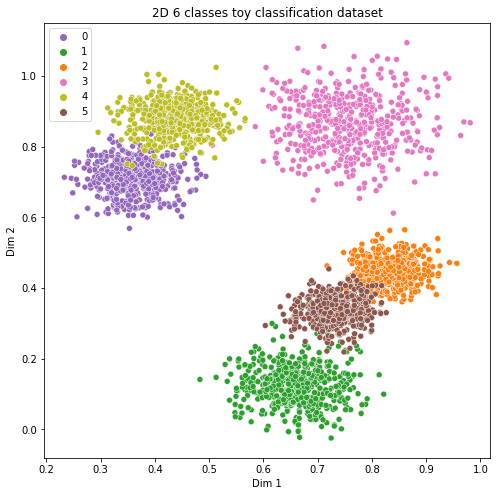

In [12]:
X, y, trainset, trainloader, testset, testloader, num_classes = data_generator.generate_data(dataset, 3000,32,6)
plot_data(X, y, num_classes, dataset, fig_path)
print(len(trainset), len(testset))

In [13]:
x_train = trainset[:][0]
y_train = trainset[:][1]
x_test = testset[:][0]
y_test = testset[:][1]

### Networks and callbacks

In [14]:
total_experts = 5

In [15]:
# fill = 'fixed'
# fill = 'fixed'
fill = 'rand'
fill = 'rand'

In [ ]:
expert_weights_init = []
expert_bias_init = []
for i in range(total_experts):
    weights = torch.zeros(num_classes,2)
    torch.nn.init.uniform_(weights)
    expert_weights_init.append(weights)
    bias = torch.zeros(num_classes)
    torch.nn.init.uniform_(bias)
    expert_bias_init.append(bias)
    print('expert '+str(i)+' weight ', weights)
    print('expert '+str(i)+' bias ', bias)

In [ ]:
gate_weights_init = torch.zeros(total_experts,2)
torch.nn.init.uniform_(gate_weights_init)
print('gate weights ', gate_weights_init)
gate_bias_init = torch.zeros(3)
torch.nn.init.uniform_(gate_bias_init)
print('gate_bias', gate_bias_init)

In [ ]:
gate_weights_init = [torch.zeros(16,2),torch.zeros(total_experts, 16)]
gate_weights_init = [torch.nn.init.uniform_(gate_weights_init[i]) for i in range(2)]
print('gate weights ', gate_weights_init)
gate_bias_init = [torch.zeros(16), torch.zeros(total_experts)]
gate_bias_init =[torch.nn.init.uniform_(gate_bias_init[i]) for i in range(2)]
print('gate_bias', gate_bias_init)

In [17]:
expert_weights_init = [None]*total_experts
expert_bias_init = [None]*total_experts
gate_weights_init = None
gate_bias_init = None

In [18]:
#Expert network
class expert_layers(nn.Module):
    def __init__(self, masks,num_classes, output, fill='rand', fill_w=None, fill_b=None):
        super(expert_layers, self).__init__()
        linear_1 = nn.Linear(2,output)
        if not fill == 'rand':
            linear_1.weight.data = fill_w
            linear_1.bias.data = fill_b
        self.model = nn.Sequential(OrderedDict({
                    'linear_1':linear_1,
                    'softmax': nn.Softmax(dim=1)
                    })
                ) 
        self.masks = masks
        self.output = output
        self.num_classes = num_classes
        
    def forward(self, input):
        output = self.model(input)
        if not self.masks is None:
            mask = torch.zeros(output.shape[0],self.num_classes)
            for m, i in zip(self.masks, range(self.output)):
                mask[:,m] = output[:,i] 
            return mask.to(device)
        return output


In [19]:
#Expert network
class expert_nonlinear_layers(nn.Module):
    def __init__(self, masks,num_classes, output, fill='rand', fill_w=None, fill_b=None):
        super(expert_nonlinear_layers, self).__init__()
        linear_1 = nn.Linear(2,16)
        linear_2 = nn.Linear(16, output)

        if not fill == 'rand':
            linear_1.weight.data = fill_w[0]
            linear_1.bias.data = fill_b[0]
            linear_2.weight.data = fill_w[1]
            linear_2.bias.data = fill_b[1]
            
        self.model = nn.Sequential(OrderedDict({
                    'linear_1':linear_1,
                    'relu':nn.ReLU(),
                    'linear_2':linear_2,
                    'softmax': nn.Softmax(dim=1)
                    })
                ) 
        self.masks = masks
        self.output = output
        self.num_classes = num_classes
        
    def forward(self, input):
        output = self.model(input)
        if not self.masks is None:
            mask = torch.zeros(output.shape[0],self.num_classes)
            for m, i in zip(self.masks, range(self.output)):
                mask[:,m] = output[:,i] 
            return mask.to(device)
        return output


In [20]:
#Expert network
class expert_layers_presoftmax(nn.Module):
    def __init__(self, masks, num_classes, output, fill='rand', fill_w=None, fill_b=None):
        super(expert_layers_presoftmax, self).__init__()
        linear_1 = nn.Linear(2,output)
        if not fill == 'rand':
            linear_1.weight.data = fill_w
            linear_1.bias.data = fill_b
        self.model = nn.Sequential(OrderedDict({
                    'linear_1':linear_1
                    })
                ) 
        self.masks = masks
        self.output = output
        self.num_classes = num_classes
        
    def forward(self, input):
        output = self.model(input)
        if not self.masks is None:
            mask = torch.zeros(output.shape[0],self.num_classes)
            for m, i in zip(self.masks, range(self.output)):
                mask[:,m] = output[:,i] 
            return mask.to(device)
        return output

In [21]:
# create a set of experts
def experts(num_experts, masks, total_num_classes, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(masks[i], total_num_classes, num_classes[i], 
                                         fill=fill, fill_w=expert_weights_init[i], fill_b=expert_bias_init[i]))
    return nn.ModuleList(models)

In [22]:
#Gate network (Similar to the expert layer)
class gate_layers(nn.Module):
    def __init__(self, num_classes, num_experts, fill='rand', fill_w=None, fill_b=None):
        super(gate_layers, self).__init__()
        linear_1 = nn.Linear(2,num_experts)
        if not fill == 'rand':
            linear_1.weight.data = fill_w
            linear_1.bias.data = fill_b
        self.model = nn.Sequential(OrderedDict({
                    'linear_1':linear_1
                    })
                )
    def forward(self, inputs, T=1.0):
        t = self.model(inputs)
        return F.softmax(t/T, dim=1)

### Mixture of experts model

In [23]:
# compute
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

In [24]:
num_epochs = 30

In [25]:
def train(trainloader, testloader, model, optimizer, loss_criterion, epochs, pre_softmax=False):
    for epoch in range(epochs):
        running_accuracy = 0.0
        num_batches = 0
        test_accuracy = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            if pre_softmax:
                outputs = F.softmax(outputs, dim=1)
            outputs = outputs.to(device)
            loss = loss_criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_accuracy += accuracy(outputs, labels)
            num_batches+=1
            
        test_batches = 0
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            test_outputs = model(inputs)
                
            if pre_softmax:
                test_outputs = F.softmax(test_outputs, dim=1)
            test_outputs = test_outputs.to(device)
            test_accuracy += accuracy(test_outputs, labels)
            test_batches += 1
            
        with torch.no_grad():
            running_accuracy = running_accuracy.cpu().numpy()/num_batches
            test_accuracy = test_accuracy.cpu().numpy()/test_batches
            print('epoch %d' % epoch,
                  ' train accuracy %.2f' % running_accuracy, 
                  'val accuracy %.2f' % test_accuracy)

In [26]:
classes_per_expert = [[0,4], [1,5], [2,3]]
class_expert_map = {0:0,1:1,2:2,3:2,4:0,5:1}

In [27]:
classes_per_expert = [[0,1], [2,3], [4,5]]
class_expert_map = {0:0,1:0,2:1,3:1,4:2,5:2}

In [28]:
classes_per_expert_str = ''
for labels in classes_per_expert:
    buffer = "_".join(str(labels).replace('[','').replace(']','').replace(',','_').replace(" ",'')).replace('_','')
    classes_per_expert_str += buffer+'_'
classes_per_expert_str = classes_per_expert_str.strip('_')
classes_per_expert_str

'01_23_45'

In [29]:
# experiment with models with different number of experts
w_importance=0.0
w_ortho = 0.0
w_ideal_gate = 0.0

augment = False
attention = False
T_max = 1
#T_decay = T_max/num_epochs
#T_decay = T_max/(num_epochs - T_decay_start)
T_decay = 0
T_decay_start = 0

def generate_plot_file(dataset, specific):
    plot_file = dataset
    if T_decay > 0:
        plot_file += '_Tdecay_'+str(T_decay)
    if T_decay_start > 0:
        plot_file += '_Tdecaystart_'+str(T_decay_start)
    if w_importance > 0:
        plot_file += '_importance_'+str(w_importance)
    if w_ortho > 0:
        plot_file += '_ortho_'+str(w_ortho)
    if augment:
        plot_file += '_augment'
    if attention:
        plot_file += '_attention'
    plot_file += '_'+str(fill)
    plot_file += '_'+specific
    
    return plot_file


In [30]:
def train_experts(total_experts, total_num_classes, num_classes, x_train, y_train, x_test, y_test,pre_softmax=False):
    batchsize = 32
    if pre_softmax:
        expert_models_copy = experts(total_experts,
                                classes_per_expert, total_num_classes, 
                                num_classes, expert_layers_presoftmax)
    else:
        expert_models_copy = experts(total_experts, 
                                classes_per_expert, total_num_classes, 
                                num_classes)
        
    expert_models = deepcopy(expert_models_copy)
    expert_models = expert_models.to(device)

    for classes, exp_i in zip(classes_per_expert, range(0,total_experts)):
                    
        index_0_1 = torch.tensor([])
        for label in classes:
            index_0_1 = np.concatenate([np.where(y_train==label)[0], index_0_1])
        
        x_0_1_train = x_train[index_0_1]
        y_0_1_train = y_train[index_0_1]

        print('train labels', np.unique(y_0_1_train))
        trainset_0_1 = torch.utils.data.TensorDataset(x_0_1_train, 
                                                      y_0_1_train)
        trainloader_0_1 = torch.utils.data.DataLoader(trainset_0_1, batch_size=batchsize,
                                                      shuffle=True, num_workers=1, pin_memory=True)
        
        index_0_1 = torch.tensor([])
        for label in classes:
            index_0_1 = np.concatenate([np.where(y_test==label)[0], index_0_1])
            
        x_0_1_test = x_test[index_0_1]
        y_0_1_test = y_test[index_0_1]
        
        print('test labels', np.unique(y_0_1_test))
        testset_0_1 = torch.utils.data.TensorDataset(x_0_1_test, 
                                                      y_0_1_test)
        testloader_0_1 = torch.utils.data.DataLoader(testset_0_1, batch_size=len(testset_0_1),
                                                  shuffle=True, num_workers=1, pin_memory=True)

        optimizer_expert = optim.RMSprop(expert_models[exp_i].parameters(), lr=0.01, momentum=0.9)

        
        loss_c = cross_entropy_loss().to(device)
        train(trainloader_0_1, testloader_0_1, expert_models[exp_i], optimizer_expert, loss_c, 20, pre_softmax)
    for i in range(0,total_experts):
        for param in expert_models[i].parameters():
            param.requires_grad = False
    return expert_models, expert_models_copy

In [ ]:
expert_models, expert_models_copy = train_experts(total_experts,num_classes, [2,2,2], x_train, y_train, x_test, y_test)

In [ ]:
plot_file = generate_plot_file(dataset, str(num_classes)+'_'+str(total_experts)+'_'+classes_per_expert_str+'_expert_model.pt')

In [ ]:
torch.save([expert_models, expert_models_copy], open(os.path.join(model_path, plot_file),'wb'))

In [ ]:
expert_models, expert_models_copy = torch.load(os.path.join(model_path, plot_file))

In [ ]:
expert_presoftmax_models, expert_presoftmax_models_copy = train_experts(total_experts, num_classes, [2,2,2], x_train, y_train, x_test, y_test, True)

In [ ]:
plot_file = generate_plot_file(dataset, str(num_classes)+'_'+str(total_experts)+'_'+classes_per_expert_str+'_expert_presoftmax_model.pt')

In [ ]:
torch.save([expert_presoftmax_models,expert_presoftmax_models_copy],open(os.path.join(model_path, plot_file),'wb'))

In [ ]:
expert_presoftmax_models, expert_presoftmax_models_copy = torch.load(os.path.join(model_path, plot_file))

In [ ]:
model_1 = 'multi_class_linear_pre_trained_expert_gate'

In [ ]:
models = {
        'moe_em_model':{'model':moe_em_model,'loss':cross_entropy_loss,'experts':{}},
        'moe_pre_softmax_expectation_model':{'model':moe_pre_softmax_expectation_model,'loss':cross_entropy_loss,'experts':{}},
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
        'moe_stochastic_model':{'model':moe_stochastic_model, 'loss':moe_stochastic_loss(cross_entropy_loss),'experts':{}}
     }

for key, val in models.items():
    print('Model:', key)
    for num_experts in range(total_experts, total_experts+1):
        print('Number of experts ', num_experts)
        if 'pre_softmax' in key:
            exp_models = expert_presoftmax_models
        else:
            exp_models = expert_models
        gate_model = gate_layers(num_classes, num_experts, fill,
                                fill_w=gate_weights_init, fill_b=gate_bias_init)
        moe_model = val['model'](num_experts, num_classes, augment, attention, exp_models, gate_model)
        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))
        optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                  lr=0.001, momentum=0.9)
        optimizer_gate = optim.RMSprop(gate_model.parameters(),
                                  lr=0.001, momentum=0.9)
        params = []
        for i, expert in enumerate(expert_models):
            params.append({'params':expert.parameters()})
        optimizer_experts = optim.RMSprop(params, lr=0.001, momentum=0.9)

        hist = moe_model.train(trainloader, testloader, val['loss'], optimizer_moe, optimizer_gate, optimizer_experts,
                               w_importance, w_ortho,
                               T=T, accuracy=accuracy, epochs=num_epochs)
        val['experts'][num_experts] = {'model':moe_model, 'history':hist}
plot_file = generate_plot_file(dataset, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(num_experts)+'_model.pt')
torch.save(models,open(os.path.join(model_path, plot_file),'wb'))    
        

In [ ]:
model_2 = 'multi_class_linear_expert_gate'

In [ ]:
models = {
#         'moe_em_model':{'model':moe_em_model,'loss':cross_entropy_loss,'experts':{}},
#         'moe_pre_softmax_expectation_model':{'model':moe_pre_softmax_expectation_model,'loss':cross_entropy_loss,'experts':{}},
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
#         'moe_stochastic_model':{'model':moe_stochastic_model, 'loss':moe_stochastic_loss(cross_entropy_loss),'experts':{}}
     }
for key, val in models.items():
    print('Model:', key)
    for num_experts in range(2, total_experts+1):
        print('Number of experts ', num_experts)
        if 'pre_softmax' in key:
            expert_models = experts(num_experts, [None]*num_experts, num_classes, [num_classes]*num_experts, expert_layers_presoftmax)
        else:
            expert_models = experts(num_experts, [None]*num_experts, num_classes, [num_classes]*num_experts)
        gate_model = gate_layers(num_classes, num_experts, fill,
                                 fill_w=gate_weights_init, fill_b=gate_bias_init)
        #plot_boundary_components(gate_model)
        moe_model = val['model'](num_experts, num_classes, augment, attention, expert_models, gate_model)
        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))
        optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                  lr=0.01, momentum=0.9)
        optimizer_gate = optim.RMSprop(gate_model.parameters(),
                                  lr=0.01, momentum=0.9)
        params = []
        for i, expert in enumerate(expert_models):
            params.append({'params':expert.parameters()})
        optimizer_experts = optim.RMSprop(params, lr=0.01, momentum=0.9)

        hist = moe_model.train(trainloader, testloader, val['loss'], optimizer_moe, optimizer_gate, optimizer_experts,  
                               w_importance, w_ortho, w_ideal_gate, 
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][num_experts] = {'model':moe_model, 'history':hist}
plot_file = generate_plot_file(model_2, str(num_classes)+'_'+str(total_experts)+'_model.pt')
torch.save(models,open(os.path.join(model_path, plot_file),'wb'))    


In [ ]:
model_3 = 'multi_class_scratch_linear_expert_gate'
model_4 = 'multi_class_pre_trained_gate_scratch_same_wts_linear_expert_gate'
model_5 = 'multi_class_pre_trained_gate_scratch_rand_wts_linear_expert_gate'

In [ ]:
for T in range(1, T_max+1):
    print('Temperature', T)
    models = {
            'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
         }
    
    models_gate_pretrained_same_wts = {
            'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
         }
    models_gate_pretrained_rand_wts = {
            'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
         }
    saved_experts = {}
    for key, val in models.items():
        print('Model:', key)
        for num_experts in range(total_experts, total_experts+1):
            print('Number of experts ', num_experts)
            if 'pre_softmax' in key:
                expert_models_copy = experts(num_experts, [None]*num_experts, num_classes, [num_classes]*num_experts, expert_layers_presoftmax)
            else:
                expert_models_copy = experts(num_experts, [None]*num_experts, num_classes, [num_classes]*num_experts)
            
            saved_experts[key] = expert_models_copy
            
            expert_models = deepcopy(expert_models_copy)
            gate_model = gate_layers(num_classes, num_experts, fill,
                                     fill_w=gate_weights_init, fill_b=gate_bias_init)
            
            moe_model = val['model'](num_experts, num_classes, augment, attention, expert_models, gate_model)
            params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
            print('model params:', sum(params))
            optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                      lr=0.01, momentum=0.9)
            optimizer_gate = optim.RMSprop(gate_model.parameters(),
                                      lr=0.01, momentum=0.9)
            params = []
            for i, expert in enumerate(expert_models):
                params.append({'params':expert.parameters()})
            optimizer_experts = optim.RMSprop(params, lr=0.01, momentum=0.9)
            
            hist = moe_model.train(trainloader, testloader, val['loss'], optimizer_moe, optimizer_gate, optimizer_experts,  
                                   w_importance, w_ortho, w_ideal_gate, T=T, T_decay=T_decay, T_decay_start=T_decay_start,
                                   accuracy=accuracy, epochs=num_epochs)
            val['experts'][num_experts] = {'model':moe_model, 'history':hist}
    plot_file = generate_plot_file(dataset_2, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(num_experts)+'_model.pt')
    torch.save(models,open(os.path.join(model_path, plot_file),'wb'))  
    
    for key, val in models_gate_pretrained_same_wts.items():
        print('Model:', key)
        for num_experts in range(total_experts, total_experts+1):
            print('Number of experts ', num_experts)

            expert_models = deepcopy(saved_experts[key])

            gate_model = models[key]['experts'][num_experts]['model'].gate
            
            # Fix the gate parameters
            for param in gate_model.parameters():
                param.requires_grad = False
            
            moe_model = val['model'](num_experts, num_classes, augment, attention, expert_models, gate_model)
            params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
            print('model params:', sum(params))
            optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                      lr=0.01, momentum=0.9)
            optimizer_gate = optim.RMSprop(gate_model.parameters(),
                                      lr=0.01, momentum=0.9)
            params = []
            for i, expert in enumerate(expert_models):
                params.append({'params':expert.parameters()})
            optimizer_experts = optim.RMSprop(params, lr=0.01, momentum=0.9)
            
            hist = moe_model.train(trainloader, testloader, val['loss'], optimizer_moe, optimizer_gate, optimizer_experts,  
                                   w_importance, w_ortho, w_ideal_gate, T=T, T_decay=T_decay, T_decay_start=T_decay_start,
                                   accuracy=accuracy, epochs=num_epochs)
            val['experts'][num_experts] = {'model':moe_model, 'history':hist}
    plot_file = generate_plot_file(dataset_3, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(num_experts)+'_model.pt')
    torch.save(models,open(os.path.join(model_path, plot_file),'wb'))    
    
    for key, val in models_gate_pretrained_rand_wts.items():
        print('Model:', key)
        for num_experts in range(total_experts, total_experts+1):
            print('Number of experts ', num_experts)
            if 'pre_softmax' in key:
                expert_models = experts(num_experts, [None]*num_experts, num_classes, [num_classes]*num_experts, expert_layers_presoftmax)
            else:
                expert_models = experts(num_experts, [None]*num_experts, num_classes, [num_classes]*num_experts)
            
            gate_model = models[key]['experts'][num_experts]['model'].gate
            
            # Fix the gate parameters
            for param in gate_model.parameters():
                param.requires_grad = False
            
            moe_model = val['model'](num_experts, num_classes, augment, attention, expert_models, gate_model)
            params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
            print('model params:', sum(params))
            optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                      lr=0.01, momentum=0.9)
            optimizer_gate = optim.RMSprop(gate_model.parameters(),
                                      lr=0.01, momentum=0.9)
            params = []
            for i, expert in enumerate(expert_models):
                params.append({'params':expert.parameters()})
            optimizer_experts = optim.RMSprop(params, lr=0.01, momentum=0.9)
            
            hist = moe_model.train(trainloader, testloader, val['loss'], optimizer_moe, optimizer_gate, optimizer_experts,  
                                   w_importance, w_ortho, w_ideal_gate, T=T, T_decay=T_decay, T_decay_start=T_decay_start,
                                   accuracy=accuracy, epochs=num_epochs)
            val['experts'][num_experts] = {'model':moe_model, 'history':hist}
    plot_file = generate_plot_file(dataset_4, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(num_experts)+'_model.pt')
    torch.save(models,open(os.path.join(model_path, plot_file),'wb'))   

In [ ]:
#Gate network (Similar to the expert layer)
class gate_nonlinear_layers(nn.Module):
    def __init__(self, num_classes, num_experts, fill='rand', fill_w=None, fill_b=None):
        super(gate_nonlinear_layers, self).__init__()
        linear_1 = nn.Linear(2,16)
        linear_2 = nn.Linear(16, num_experts)

        if not fill == 'rand':
            linear_1.weight.data = fill_w[0]
            linear_1.bias.data = fill_b[0]
            linear_2.weight.data = fill_w[1]
            linear_2.bias.data = fill_b[1]
        self.model = nn.Sequential(OrderedDict({
                    'linear_1':linear_1,
                    'relu':nn.ReLU(),
                    'linear_2':linear_2,
                    })
                )
    def forward(self, input, T=1.0):
        t = self.model(input)
        return F.softmax(t/T, dim=1)

In [ ]:
model_6 = 'multi_class_scratch_linear_expert_nonlinear_gate'
model_7 = 'multi_class_pre_trained_gate_scratch_same_wts_linear_expert_nonlinear_gate'
model_8 = 'multi_class_pre_trained_gate_scratch_rand_wts_linear_expert_nonlinear_gate'

In [ ]:
for T in range(1, T_max+1):
    print('Temperature', T)
    models = {
            'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
         }
    
    models_gate_pretrained_same_wts = {
            'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
         }
    models_gate_pretrained_rand_wts = {
            'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
         }
    saved_experts = {}
    for key, val in models.items():
        print('Model:', key)
        for num_experts in range(total_experts, total_experts+1):
            print('Number of experts ', num_experts)
            if 'pre_softmax' in key:
                expert_models_copy = experts(num_experts, [None]*num_experts, num_classes, [num_classes]*num_experts, expert_layers_presoftmax)
            else:
                expert_models_copy = experts(num_experts, [None]*num_experts, num_classes, [num_classes]*num_experts)
            
            saved_experts[key] = expert_models_copy
            
            expert_models = deepcopy(expert_models_copy)
            gate_model = gate_nonlinear_layers(num_classes, num_experts, fill,
                                     fill_w=gate_weights_init, fill_b=gate_bias_init)
                        
            moe_model = val['model'](num_experts, num_classes, augment, attention, expert_models, gate_model)
            params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
            print('model params:', sum(params))
            optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                      lr=0.01, momentum=0.9)
            optimizer_gate = optim.RMSprop(gate_model.parameters(),
                                      lr=0.01, momentum=0.9)
            params = []
            for i, expert in enumerate(expert_models):
                params.append({'params':expert.parameters()})
            optimizer_experts = optim.RMSprop(params, lr=0.01, momentum=0.9)
            
            hist = moe_model.train(trainloader, testloader, val['loss'], optimizer_moe, optimizer_gate, optimizer_experts,  
                                   w_importance, w_ortho, w_ideal_gate, T=T, T_decay=T_decay, T_decay_start=T_decay_start,
                                   accuracy=accuracy, epochs=num_epochs)
            val['experts'][num_experts] = {'model':moe_model, 'history':hist}
    plot_file = generate_plot_file(dataset_6, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(num_experts)+'_model.pt')
    torch.save(models,open(os.path.join(model_path, plot_file),'wb'))  
    
    for key, val in models_gate_pretrained_same_wts.items():
        print('Model:', key)
        for num_experts in range(total_experts, total_experts+1):
            print('Number of experts ', num_experts)

            expert_models = deepcopy(saved_experts[key])
            gate_model = models[key]['experts'][num_experts]['model'].gate
            
            # Fix the gate parameters
            for param in gate_model.parameters():
                param.requires_grad = False
            
            moe_model = val['model'](num_experts, num_classes, augment, attention, expert_models, gate_model)
            params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
            print('model params:', sum(params))
            optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                      lr=0.01, momentum=0.9)
            optimizer_gate = optim.RMSprop(gate_model.parameters(),
                                      lr=0.01, momentum=0.9)
            params = []
            for i, expert in enumerate(expert_models):
                params.append({'params':expert.parameters()})
            optimizer_experts = optim.RMSprop(params, lr=0.01, momentum=0.9)
            
            hist = moe_model.train(trainloader, testloader, val['loss'], optimizer_moe, optimizer_gate, optimizer_experts,  
                                   w_importance, w_ortho, w_ideal_gate, T=T, T_decay=T_decay, T_decay_start=T_decay_start,
                                   accuracy=accuracy, epochs=num_epochs)
            val['experts'][num_experts] = {'model':moe_model, 'history':hist}
    plot_file = generate_plot_file(dataset_7, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(num_experts)+'_model.pt')
    torch.save(models,open(os.path.join(model_path, plot_file),'wb'))    
    
    for key, val in models_gate_pretrained_rand_wts.items():
        print('Model:', key)
        for num_experts in range(total_experts, total_experts+1):
            print('Number of experts ', num_experts)
            if 'pre_softmax' in key:
                expert_models = experts(num_experts, [None]*num_experts, num_classes, [num_classes]*num_experts, expert_layers_presoftmax)
            else:
                expert_models = experts(num_experts, [None]*num_experts, num_classes, [num_classes]*num_experts)
            
            gate_model = models[key]['experts'][num_experts]['model'].gate
            
            # Fix the gate parameters
            for param in gate_model.parameters():
                param.requires_grad = False
            
            moe_model = val['model'](num_experts, num_classes, augment, attention, expert_models, gate_model)
            params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
            print('model params:', sum(params))
            optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                      lr=0.01, momentum=0.9)
            optimizer_gate = optim.RMSprop(gate_model.parameters(),
                                      lr=0.01, momentum=0.9)
            params = []
            for i, expert in enumerate(expert_models):
                params.append({'params':expert.parameters()})
            optimizer_experts = optim.RMSprop(params, lr=0.01, momentum=0.9)
            
            hist = moe_model.train(trainloader, testloader, val['loss'], optimizer_moe, optimizer_gate, optimizer_experts,  
                                   w_importance, w_ortho, w_ideal_gate, T=T, T_decay=T_decay, T_decay_start=T_decay_start,
                                   accuracy=accuracy, epochs=num_epochs)
            val['experts'][num_experts] = {'model':moe_model, 'history':hist}
    plot_file = generate_plot_file(dataset_8, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(num_experts)+'_model.pt')
    torch.save(models,open(os.path.join(model_path, plot_file),'wb'))   

In [ ]:
dataset_9 = 'multi_class_pre_trained_gate_prechosen_linear_expert_gate'
dataset_10 = 'multi_class_pre_trained_gate_prechosen_same_wts_linear_expert_gate'
dataset_11 = 'multi_class_pre_trained_gate_prechosen_rand_wts_linear_expert_gate'

In [ ]:
for T in range(1, T_max+1):
    print('Temperature', T)
    models = {
            'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
         }
    models_gate_pretrained_same_wts = {
            'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
         }
    models_gate_pretrained_rand_wts = {
            'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
         }
    for key, val in models.items():
        print('Model:', key)
        for num_experts in range(total_experts, total_experts+1):
            print('Number of experts ', num_experts)

            expert_models = expert_models

            gate_model = gate_layers(num_classes, num_experts, fill,
                                     fill_w=gate_weights_init, fill_b=gate_bias_init)
             
            moe_model = val['model'](num_experts, num_classes, augment, attention, expert_models, gate_model)
            params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
            print('model params:', sum(params))
            optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                      lr=0.01, momentum=0.9)
            optimizer_gate = optim.RMSprop(gate_model.parameters(),
                                      lr=0.01, momentum=0.9)
            params = []
            for i, expert in enumerate(expert_models):
                params.append({'params':expert.parameters()})
            optimizer_experts = optim.RMSprop(params, lr=0.01, momentum=0.9)
            
            hist = moe_model.train(trainloader, testloader, val['loss'], optimizer_moe, optimizer_gate, optimizer_experts,  
                                   w_importance, w_ortho, w_ideal_gate, T=T, T_decay=T_decay, T_decay_start=T_decay_start,
                                   accuracy=accuracy, epochs=num_epochs)
            val['experts'][num_experts] = {'model':moe_model, 'history':hist}
    plot_file = generate_plot_file(dataset_9, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_model.pt')
    torch.save(models,open(os.path.join(model_path, plot_file),'wb'))    

    for key, val in models_gate_pretrained_same_wts.items():
        print('Model:', key)
        for num_experts in range(total_experts, total_experts+1):
            print('Number of experts ', num_experts)
            
            expert_models = expert_models_copy
            
            gate_model = models[key]['experts'][num_experts]['model'].gate
            # Fix the gate parameters
            for param in gate_model.parameters():
                param.requires_grad = False
                
            moe_model = val['model'](num_experts, num_classes, augment, attention, expert_models, gate_model)
            params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
            print('model params:', sum(params))
            optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                      lr=0.01, momentum=0.9)
            optimizer_gate = optim.RMSprop(gate_model.parameters(),
                                      lr=0.01, momentum=0.9)
            params = []
            for i, expert in enumerate(expert_models):
                params.append({'params':expert.parameters()})
            optimizer_experts = optim.RMSprop(params, lr=0.01, momentum=0.9)
            
            hist = moe_model.train(trainloader, testloader, val['loss'], optimizer_moe, optimizer_gate, optimizer_experts,  
                                   w_importance, w_ortho, w_ideal_gate, T=T, T_decay=T_decay, T_decay_start=T_decay_start,
                                   accuracy=accuracy, epochs=num_epochs)
            val['experts'][num_experts] = {'model':moe_model, 'history':hist}
    plot_file = generate_plot_file(dataset_10, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_model.pt')
    torch.save(models,open(os.path.join(model_path, plot_file),'wb'))    

    for key, val in models_gate_pretrained_rand_wts.items():
        print('Model:', key)
        for num_experts in range(total_experts, total_experts+1):
            print('Number of experts ', num_experts)
            if 'pre_softmax' in key:
                expert_models = experts(num_experts, [None]*num_experts, num_classes, [num_classes]*num_experts, expert_layers_presoftmax)
            else:
                expert_models = experts(num_experts, [None]*num_experts, num_classes, [num_classes]*num_experts)
            
            gate_model = models[key]['experts'][num_experts]['model'].gate
            # Fix the gate parameters
            for param in gate_model.parameters():
                param.requires_grad = False
                
            moe_model = val['model'](num_experts, num_classes, augment, attention, expert_models, gate_model)
            params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
            print('model params:', sum(params))
            optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                      lr=0.01, momentum=0.9)
            optimizer_gate = optim.RMSprop(gate_model.parameters(),
                                      lr=0.01, momentum=0.9)
            params = []
            for i, expert in enumerate(expert_models):
                params.append({'params':expert.parameters()})
            optimizer_experts = optim.RMSprop(params, lr=0.01, momentum=0.9)
            
            hist = moe_model.train(trainloader, testloader, val['loss'], optimizer_moe, optimizer_gate, optimizer_experts,  
                                   w_importance, w_ortho, w_ideal_gate, T=T, T_decay=T_decay, T_decay_start=T_decay_start,
                                   accuracy=accuracy, epochs=num_epochs)
            val['experts'][num_experts] = {'model':moe_model, 'history':hist}
    plot_file = generate_plot_file(dataset_11, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_model.pt')
    torch.save(models,open(os.path.join(model_path, plot_file),'wb'))    
        

In [ ]:
model_12 =  'multi_class_mixed_expert_linear_gate'

In [ ]:
n_runs = 10
n_models = []
for n_run in range(n_runs):
    print('RUN ', n_run)
    models = {
            'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
         }
    for key, val in models.items():
        print('Model:', key)
        num_experts = 2
        print('Number of experts ', num_experts)
        expert_model_linear = expert_layers(None, num_classes, num_classes, 
                                     fill=fill, fill_w=expert_weights_init[0], fill_b=expert_bias_init[0])
        expert_model_nonlinear = expert_nonlinear_layers(None, num_classes, num_classes, 
                                     fill=fill, fill_w=expert_weights_init[1], fill_b=expert_bias_init[1])
        expert_models = nn.ModuleList([expert_model_linear, expert_model_nonlinear])

        gate_model = gate_layers(num_classes, 2, fill,
                                 fill_w=gate_weights_init, fill_b=gate_bias_init)
        #plot_boundary_components(gate_model)
        moe_model = val['model'](2, num_classes, augment, attention, expert_models, gate_model)
        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))
        optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                  lr=0.01, momentum=0.9)
        optimizer_gate = optim.RMSprop(gate_model.parameters(),
                                  lr=0.01, momentum=0.9)
        params = []
        for i, expert in enumerate(expert_models):
            params.append({'params':expert.parameters()})
        optimizer_experts = optim.RMSprop(params, lr=0.01, momentum=0.9)

        hist = moe_model.train(trainloader, testloader, val['loss'], optimizer_moe, optimizer_gate, optimizer_experts,  
                               w_importance, w_ortho, w_ideal_gate, 
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][num_experts] = {'model':moe_model, 'history':hist}
    n_models.append(models)
plot_file = generate_plot_file(model_12, str(num_classes)+'_'+str(num_experts)+'_model.pt')
torch.save(n_models,open(os.path.join(model_path, plot_file),'wb'))    


In [ ]:
num_experts = 2
n_runs = 10
plot_file = generate_plot_file(model_12, str(num_classes)+'_'+str(num_experts)+'_model.pt')
print(plot_file)
n_models = torch.load(open(os.path.join(model_path, plot_file),'rb'))    

history_samples = []
history_loss = []
for model in n_models:
    history_samples.append(model['moe_expectation_model']['experts'][2]['history']['exp_samples'])
    history_loss.append(model['moe_expectation_model']['experts'][2]['history']['expert_sample_loss'])
exp_samples = np.asarray(history_samples)
exp_loss = np.asarray(history_loss)

plt.plot(range(num_epochs), np.mean(exp_samples[:,:,0], axis=0))
plt.plot(range(num_epochs), np.mean(exp_samples[:,:,1], axis=0))
plt.legend(['linear expert', 'nonlinear expert'])
plt.xlabel('epochs')
plt.ylabel('average training samples')
image_file = generate_plot_file(model_12, 'samples_'+str(num_classes)+'_'+str(num_experts)+'_experts.png')
plt.savefig(os.path.join(fig_path, image_file))
plt.show()

plt.plot(range(num_epochs), np.mean(exp_loss[:,:,0], axis=0))
plt.plot(range(num_epochs), np.mean(exp_loss[:,:,1], axis=0))
plt.legend(['linear expert', 'nonlinear expert'])
plt.xlabel('epochs')
plt.ylabel('average training loss')
image_file = generate_plot_file(model_12, 'loss_'+str(num_classes)+'_'+str(num_experts)+'_experts.png')
plt.savefig(os.path.join(fig_path, image_file))
plt.show()
image_file = generate_plot_file(model_12, 'gate_decisions'+str(num_classes)+'_'+str(num_experts)+'_experts.png')
generated_data = generate_meshgrid(X).to(device)
visualize(n_models[0], num_experts, num_classes, generated_data, 
                    testset[:][0].to(device), testset[:][1].to(device), filename=filename)

In [31]:
model_13 =  'multi_class_linear_expert_gate'

In [34]:
n_runs = 10
n_models = []
for n_run in range(n_runs):
    print('RUN ', n_run)
    models = {
            'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
         }
    for key, val in models.items():
        print('Model:', key)
        num_experts = 2
        print('Number of experts ', num_experts)
        
        expert_models = experts(num_experts, [None]*num_experts, num_classes, [num_classes]*num_experts)

        gate_model = gate_layers(num_classes, num_experts, fill,
                                 fill_w=gate_weights_init, fill_b=gate_bias_init)
        #plot_boundary_components(gate_model)
        moe_model = val['model'](2, num_classes, augment, attention, expert_models, gate_model)
        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))
        optimizer_moe = optim.RMSprop(gate_model.parameters(),
                                  lr=0.01, momentum=0.9)
        lr = [0.01,0.0001]
        for i, expert in enumerate(expert_models):
            optimizer_moe.add_param_group({'params': expert.parameters(), 'lr':lr[i]})

        hist = moe_model.train(trainloader, testloader, val['loss'], optimizer_moe, 
                               None, None,  
                               w_importance, w_ortho, w_ideal_gate, 
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][num_experts] = {'model':moe_model, 'history':hist}
    n_models.append(models)
plot_file = generate_plot_file(model_13, str(num_classes)+'_'+str(num_experts)+''+str(n_runs)+'_model.pt')
torch.save(n_models,open(os.path.join(model_path, plot_file),'wb'))    


RUN  0
Model: moe_expectation_model
Number of experts  2
model params: 42
epoch 0 training loss 1.10 , training accuracy 0.67 , test accuracy 0.90
epoch 1 training loss 0.68 , training accuracy 0.86 , test accuracy 0.83
epoch 2 training loss 0.56 , training accuracy 0.92 , test accuracy 0.96
epoch 3 training loss 0.49 , training accuracy 0.94 , test accuracy 0.91
epoch 4 training loss 0.44 , training accuracy 0.94 , test accuracy 0.93
epoch 5 training loss 0.40 , training accuracy 0.95 , test accuracy 0.98
epoch 6 training loss 0.36 , training accuracy 0.96 , test accuracy 0.97
epoch 7 training loss 0.33 , training accuracy 0.97 , test accuracy 0.98
epoch 8 training loss 0.31 , training accuracy 0.97 , test accuracy 0.93
epoch 9 training loss 0.29 , training accuracy 0.96 , test accuracy 0.95
epoch 10 training loss 0.27 , training accuracy 0.97 , test accuracy 0.97
epoch 11 training loss 0.25 , training accuracy 0.97 , test accuracy 0.96
epoch 12 training loss 0.24 , training accuracy 

multi_class_linear_expert_gate_rand_6_210_model.pt


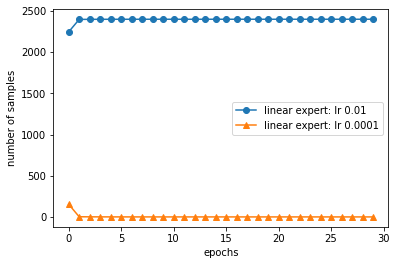

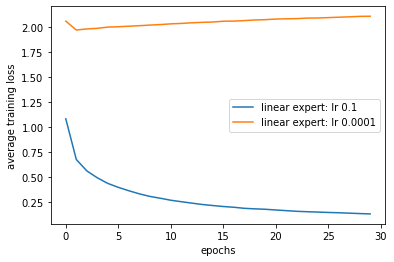

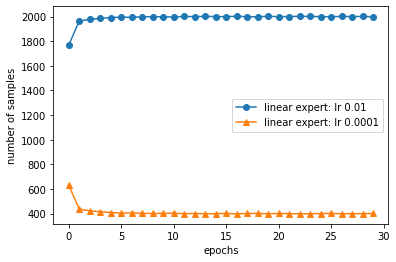

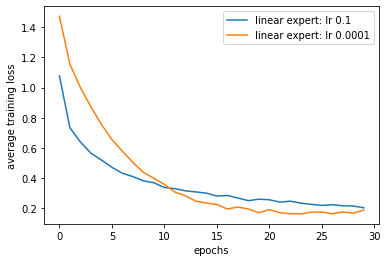

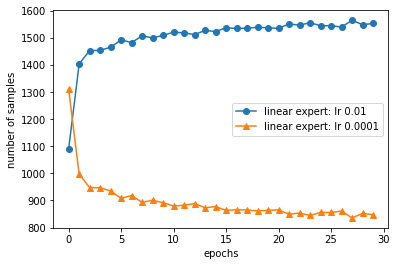

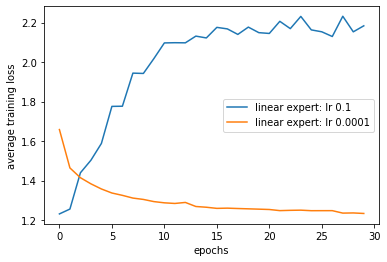

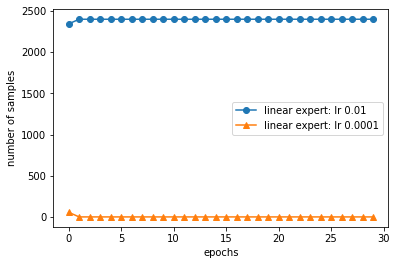

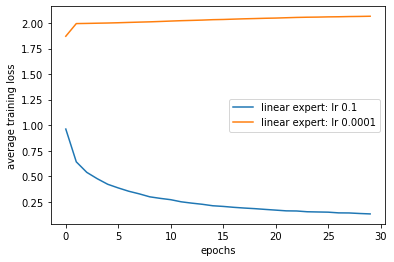

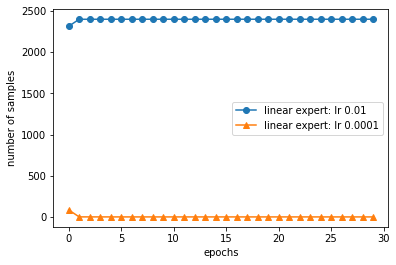

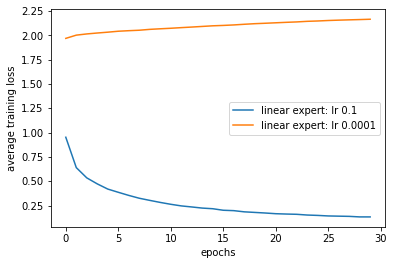

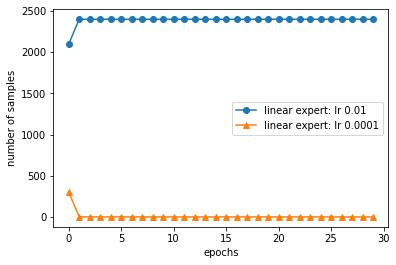

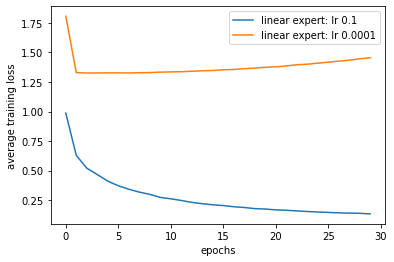

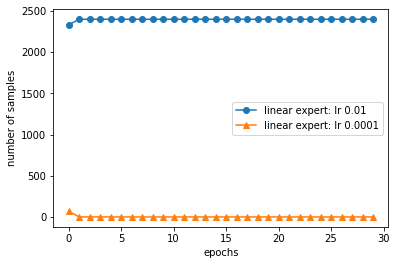

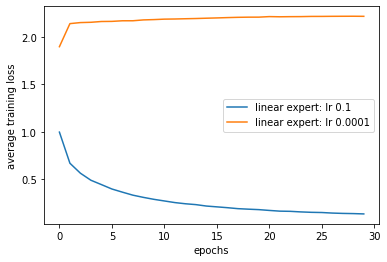

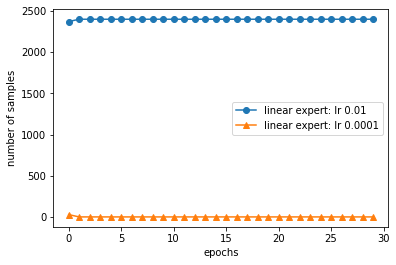

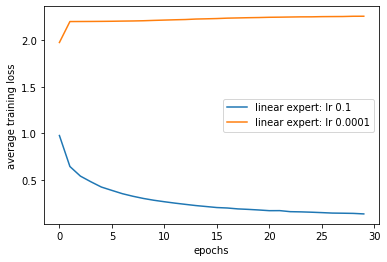

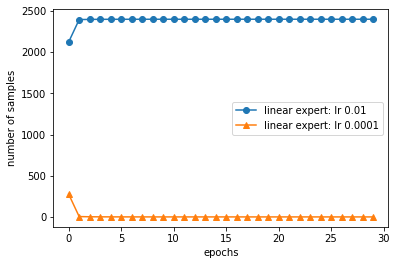

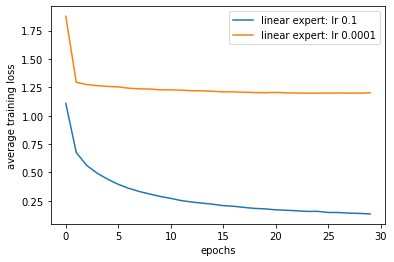

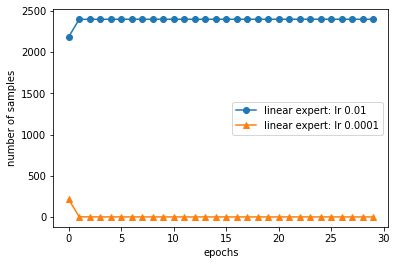

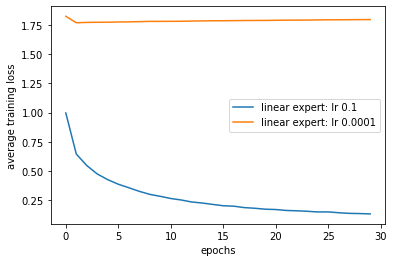

(10, 30, 2)
(10, 30, 2)


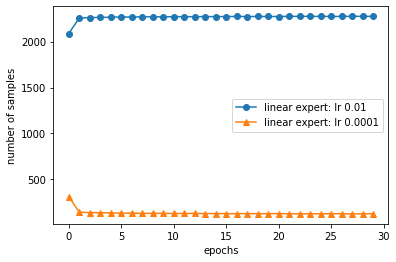

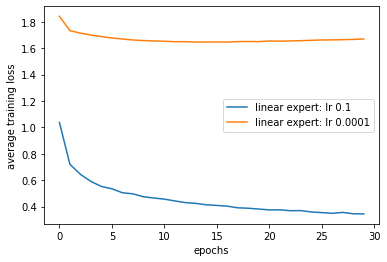

NameError: name 'generate_meshgrid' is not defined

In [37]:
num_experts = 2
n_runs = 10
plot_file = generate_plot_file(model_13, str(num_classes)+'_'+str(num_experts)+''+str(n_runs)+'_model.pt')
print(plot_file)
n_models = torch.load(open(os.path.join(model_path, plot_file),'rb'))    

history_samples = []
history_loss = []
for model in n_models:
    expert_samples = model['moe_expectation_model']['experts'][2]['history']['exp_samples']
    expert_loss = model['moe_expectation_model']['experts'][2]['history']['expert_sample_loss']
    history_samples.append(expert_samples)
    history_loss.append(expert_loss)
    
    plt.plot(range(num_epochs), np.asarray(expert_samples)[:,0], marker='o',color='tab:blue')
    plt.plot(range(num_epochs), np.asarray(expert_samples)[:,1], marker='^',color='tab:orange')
    plt.legend(['linear expert: lr 0.01', 'linear expert: lr 0.0001'])
    plt.xlabel('epochs')
    plt.ylabel('number of samples')
    image_file = generate_plot_file(model_13, 'linear_vs_linear_samples_'+str(num_classes)+'_'+str(num_experts)+'_experts.png')
    plt.savefig(os.path.join(fig_path, image_file))
    plt.show()

    plt.plot(range(num_epochs), np.asarray(expert_loss)[:,0])
    plt.plot(range(num_epochs), np.asarray(expert_loss)[:,1])
    plt.legend(['linear expert: lr 0.1', 'linear expert: lr 0.0001'])
    plt.xlabel('epochs')
    plt.ylabel('average training loss')
    image_file = generate_plot_file(model_13, 'linear_vs_linear_loss_'+str(num_classes)+'_'+str(num_experts)+'_experts.png')
    plt.savefig(os.path.join(fig_path, image_file))
    plt.show()

exp_samples = np.asarray(history_samples)
print(exp_samples.shape)
exp_loss = np.asarray(history_loss)
print(exp_loss.shape)
    
exp_samples = np.asarray(history_samples)
plt.plot(range(num_epochs), np.mean(exp_samples[:,:,0], axis=0), marker='o',color='tab:blue')
plt.plot(range(num_epochs), np.mean(exp_samples[:,:,1], axis=0), marker='^',color='tab:orange')
plt.legend(['linear expert: lr 0.01', 'linear expert: lr 0.0001'])
plt.xlabel('epochs')
plt.ylabel('number of samples')
image_file = generate_plot_file(model_13, 'linear_vs_linear_samples_'+str(num_classes)+'_'+str(num_experts)+'_experts.png')
plt.savefig(os.path.join(fig_path, image_file))
plt.show()

plt.plot(range(num_epochs), np.mean(exp_loss[:,:,0], axis=0))
plt.plot(range(num_epochs), np.mean(exp_loss[:,:,1], axis=0))
plt.legend(['linear expert: lr 0.1', 'linear expert: lr 0.0001'])
plt.xlabel('epochs')
plt.ylabel('average training loss')
image_file = generate_plot_file(model_13, 'linear_vs_linear_loss_'+str(num_classes)+'_'+str(num_experts)+'_experts.png')
plt.savefig(os.path.join(fig_path, image_file))
plt.show()

filename = generate_plot_file(model_13, 'linear_vs_linear_gate_decisions'+str(num_classes)+'_'+str(num_experts)+'_experts.png')
generated_data = generate_meshgrid(X).to(device)
visualize(model, num_experts, num_classes, generated_data, 
                    testset[:][0].to(device), testset[:][1].to(device), filename=filename)

In [ ]:
plot_file = generate_plot_file(dataset_1, 'T_'+str(T_max)+'_'+str(num_classes)+'_'+str(total_experts)+'_model.pt')
models_random = torch.load(open(os.path.join(model_path, plot_file),'rb'))

In [ ]:
plot_file = generate_plot_file(dataset, 'T_'+str(T_max)+'_'+str(num_classes)+'_'+str(total_experts)+'_model.pt')
models_pre_trained = torch.load(open(os.path.join(model_path, plot_file),'rb'))

In [ ]:
fig,ax = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(32,4))
index = 0
for m_pt, m in zip(models_pre_trained.items(), models_random.items()):
    mkey_pt, mval_pt = m_pt
    mkey, mval = m
    for i in range(total_experts, total_experts+1):
        history = mval['experts'][i]['history']
        history_pt = mval_pt['experts'][i]['history']
        legend_labels = ['pre_trained', 'not pre_trained']
        ax[index].plot(range(num_epochs), history_pt['loss'], marker='o',color='tab:blue')
        ax[index].plot(range(num_epochs), history['loss'], marker='o', color='tab:orange')   
        ax[index].set_ylim(bottom=0)
        ax[index].set_title(mkey+'\n'+'Training loss for ' + str(i) + ' Experts')
        ax[index].legend(legend_labels)
        ax[index].set_xlabel('Number of epochs')
        ax[index].set_xlim(0, num_epochs)
        ax[index].set_ylabel('loss')
    index+=1

image_file = generate_plot_file(dataset_3, classes_per_expert_str+'_loss_compare_T_'+str(T)+'_'+str(num_classes)+'_'+str(i)+'_experts.png')
plt.savefig(os.path.join(fig_path, image_file))

In [ ]:
fig,ax = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(32,4))
index = 0
for m_pt, m in zip(models_pre_trained.items(), models_random.items()):
    mkey_pt, mval_pt = m_pt
    mkey, mval = m
    for i in range(total_experts, total_experts+1):

        history = mval['experts'][i]['history']
        history_pt = mval_pt['experts'][i]['history']
        legend_labels = ['pre_trained', 'not pre_trained']
        ax[index].plot(range(num_epochs), 1-torch.tensor(history_pt['val_accuracy']), marker='o',color='tab:blue')
        ax[index].plot(range(num_epochs), 1-torch.tensor(history['val_accuracy']), marker='o', color='tab:orange')            
        ax[index].set_ylim(0,1)
        ax[index].set_title(mkey+'\n'+'Training error for ' + str(i) + ' Experts')
        ax[index].legend(legend_labels)
        ax[index].set_xlabel('Number of epochs')
        ax[index].set_xlim(0, num_epochs)
        ax[index].set_ylabel('error')
    index+=1
image_file = generate_plot_file(dataset_3, classes_per_expert_str+'_error_compare_T_'+str(T)+'_'+str(num_classes)+'_'+str(i)+'_experts.png')
plt.savefig(os.path.join(fig_path, image_file))

In [ ]:
plt.rcParams["figure.figsize"] = (8,4)
plot_file = generate_plot_file(model_2, str(num_classes)+'_'+str(total_experts)+'_model.pt')
print('model: ', plot_file)
models = torch.load(os.path.join(model_path, plot_file))

# for i in range(2, total_experts+1):
for i in range(2, 3):
    legend_labels = [r'$H_b$ - Expert selection entropy', r'$H_a$ - Expert selection by sample entropy']
    for m_key, m_val in models.items():
        fig,ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8,4))
#         ax = ax.flatten()

        history = m_val['experts'][i]['history']
    
        print(min(history['sample_entropy']))
    
        ax.plot(range(num_epochs), history['entropy'], marker='o',color='tab:blue') 
        ax.plot(range(num_epochs), history['sample_entropy'], marker='^', color='tab:orange') 
        
        ax.set_ylim(0, 2.5)
        ax.set_title(m_key)
        ax.set_xlabel('epochs')
        ax.set_xlim(0, num_epochs)
        ax.set_ylim(bottom=0)
        ax.set_ylabel('entropy')
        ax.legend(legend_labels)

        image_file = generate_plot_file(model_2+'_'+m_key+'_entropy',str(num_classes)+'_'+str(i)+'_experts.png')
        plt.savefig(os.path.join(fig_path, image_file))
        plt.show()


In [ ]:
plt.rcParams["figure.figsize"] = (8,4)
for T in range(1, T_max+1):
            
    for i in range(total_experts, total_experts+1):
        
        plot_file = generate_plot_file(dataset_1,'T_'+str(T)+'_'+str(num_classes)+'_'+str(i)+'_model.pt')
        print('model: ', plot_file)
        models = torch.load(os.path.join(model_path, plot_file))
        fig,ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8,4))
        legend_labels = []

        for m_key, m_val in models.items():
            
            legend_labels.append(m_key)
            history = m_val['experts'][i]['history']
            ax.plot(range(len(history['val_accuracy'])), 1-np.asarray(history['val_accuracy']))

            ax.set_title('Error Rate for ' + str(i) + ' Experts')
            ax.legend(legend_labels)
            ax.set_xlabel('Number of epochs')
            ax.set_xlim(0, num_epochs)
            ax.set_ylim(0, 1.0)
            ax.set_ylabel('Error')

        image_file = generate_plot_file(dataset_1, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(i)+'_experts.png')
        plt.savefig(os.path.join(fig_path, 'error_rate_'+image_file))

        plt.show()


In [ ]:
plt.rcParams["figure.figsize"] = (8,4)
for T in range(1, T_max+1):
            
    for i in range(total_experts, total_experts+1):
        
        plot_file = generate_plot_file(dataset_3,'T_'+str(T)+'_'+str(num_classes)+'_'+str(i)+'_model.pt')
        print('model: ', plot_file)
        models = torch.load(os.path.join(model_path, plot_file))
        fig,ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8,4))
        legend_labels = []

        for m_key, m_val in models.items():
            
            legend_labels.append(m_key)
            history = m_val['experts'][i]['history']
            ax.plot(range(len(history['val_accuracy'])), 1-np.asarray(history['val_accuracy']))

            ax.set_title('Error Rate for ' + str(i) + ' Experts')
            ax.legend(legend_labels)
            ax.set_xlabel('Number of epochs')
            ax.set_xlim(0, num_epochs)
            ax.set_ylim(0, 1.0)
            ax.set_ylabel('Error')

        image_file = generate_plot_file(dataset_3, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(i)+'_experts.png')
        plt.savefig(os.path.join(fig_path, 'error_rate_'+image_file))

        plt.show()


In [ ]:
plt.rcParams["figure.figsize"] = (8,4)
for T in range(1, T_max+1):
    plot_file = generate_plot_file(dataset, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_model.pt')
    models = torch.load(os.path.join(model_path, plot_file))

    for m_key, m_val in models.items():
        print('Mutual information for ', m_key)
        legend_labels = []
        for i in range(total_experts, total_experts+1):
            history = m_val['experts'][i]['history']

            plt.plot(range(len(history['mutual_EY'])), history['mutual_EY'], marker='o')

            legend_labels.append('E'+str(i))
        plt.title('Mutual information of gate and classes: ' + str(i) + ' Experts')
        plt.xlabel('Number of epochs')
        plt.xlim(0, num_epochs)
        plt.ylabel('Mutual Information')
        image_file = generate_plot_file(dataset+'_'+m_key, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(i)+'_experts.png')
        plt.savefig(os.path.join(fig_path, 'mutual_info_'+image_file))

        plt.show()
        

### Visualise decision boundaries of mixture of expert model, expert model and gate model

In [ ]:
#create meshgrid
def generate_meshgrid(X):
    resolution = 100 # 100x100 background pixels
    a2d_min, a2d_max = np.min(X[:,0]), np.max(X[:,0])
    b2d_min, b2d_max = np.min(X[:,1]), np.max(X[:,1])
    a, b = np.meshgrid(np.linspace(a2d_min, a2d_max, resolution), 
                       np.linspace(b2d_min, b2d_max, resolution))
    generated_data = torch.tensor(np.c_[a.ravel(), b.ravel()], dtype=torch.float32)
    return generated_data

In [ ]:
def labels(p, palette=palette):
    pred_labels = torch.argmax(p, dim=1)
    uniq_y = np.unique(pred_labels)
    pred_color = [palette[i] for i in uniq_y]
    return pred_color, pred_labels

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def predict(dataloader, model):
        
        pred_labels = []
        true_labels = []
        for i, data in enumerate(dataloader):
            inputs, labels = data
            true_labels.append(labels)
            pred_labels.append(torch.argmax(model(inputs), dim=1))
            
        return torch.stack(true_labels), torch.stack(pred_labels)

In [ ]:
def lighten_color(colors, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    
    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    l_colors = []
    for color in colors:
        try:
            c = mc.cnames[color]
        except:
            c = color
        c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
        l_color = colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])
        l_colors.append(l_color)
    return l_colors

In [ ]:
def visualize(models, total_experts, num_classes, generated_data, 
              X_orig_data, y_orig_data, filename):
    keys = models.keys()
    print(keys)
    N = len(keys)
#     fontsize = 25-((N-1)*5)
#     fontsize1 = 20-((N-1)*3)
#     labelsize = 20-((N-1)*3)
#     legendsize = 18-((N-1)*3)

    fontsize = 14
    fontsize1 = 8
    labelsize = 11
    legendsize = 11
    
    index = 0
    visible = True
    for m_key, m_val in models.items():
        
        for num_experts in range(2, 3):
#         for num_experts in range(2, total_experts+1):
            
            nrows = 1
            ncols = num_experts + 1

            thefigsize = (ncols*6, nrows*6)
            fig, ax = plt.subplots(nrows, ncols, sharex=False, sharey=True, figsize=thefigsize)

            print('\n',m_key)
            moe_model = m_val['experts'][num_experts]['model'].to(device)

            pred_orig_data = moe_model(X_orig_data)

            orig_data_gate_outputs = moe_model.gate_outputs
            print(orig_data_gate_outputs)
            orig_data_expert_outputs = moe_model.expert_outputs
            if 'stochastic' in m_key:
                orig_data_samples = moe_model.samples

            pred_orig_data_color,pred_orig_data_labels = labels(pred_orig_data.cpu())

            pred_gen_data = moe_model(generated_data)
            pred_gen_data_expert_output = moe_model.expert_outputs

            pred_gen_data_color,pred_gen_data_labels = labels(pred_gen_data.cpu())

            palette_gate = sns.color_palette("Paired")+sns.color_palette('Set2')
            pred_gate_gen_data_output = moe_model.gate_outputs
            pred_gate_gen_data_color, pred_gate_gen_data_labels = labels(pred_gate_gen_data_output.cpu(), palette_gate)

            u_gate_labels = np.unique(pred_gate_gen_data_labels)
            sorted_labels = np.argsort(pred_gate_gen_data_labels)
            legend_labels = ['Expert '+str(l.item()+1) for l in pred_gate_gen_data_labels[sorted_labels]]
            sns.scatterplot(x=generated_data[:,0][sorted_labels].cpu(),y=generated_data[:,1][sorted_labels].cpu(),
                            hue=legend_labels, legend=visible, palette=pred_gate_gen_data_color, s=10, ax=ax[0])
            sns.scatterplot(x=X_orig_data[:,0].cpu() , y=X_orig_data[:,1].cpu() , 
                            hue=pred_orig_data_labels, palette=pred_orig_data_color, legend=visible, s=40,ax=ax[0])
            indices = np.where((pred_orig_data_labels == y_orig_data.cpu() )== False)[0]
            sns.scatterplot(x=X_orig_data[indices,0].cpu(),y=X_orig_data[indices,1].cpu(),
                            hue=['mis-classified']*len(indices), palette=['r'], marker='X', legend=visible, s=40, ax=ax[0])
            # Put a legend below current axis
            ax[0].legend(loc='upper left', bbox_to_anchor=(0.0, -0.1), fancybox=True, shadow=True,
                         ncol=len(u_gate_labels)+num_classes+1, fontsize=legendsize, markerscale=2.)
            ax[0].set_title('Mixture of Experts', fontsize=fontsize)
            ax[0].set_ylabel('Dim 2', fontsize=fontsize1)
            ax[0].set_xlabel('Dim 1', fontsize=fontsize1)
            ax[0].tick_params(labelsize=labelsize)

            for i in range(0, num_experts):
                if 'pre_softmax' in m_key:
                    pred_orig_data_expert_color,pred_orig_data_expert_labels = labels(F.softmax(orig_data_expert_outputs[:,i,:].cpu(), dim=1))
                else:
                    pred_orig_data_expert_color,pred_orig_data_expert_labels = labels(orig_data_expert_outputs[:,i,:].cpu())

                index = np.where(pred_gate_gen_data_labels==i)[0]
                color = np.unique(pred_gate_gen_data_labels[index].cpu())
                if len(color) > 0:
                    sns.scatterplot(x=generated_data[:,0][index].cpu(),y=generated_data[:,1][index].cpu(),
                                    hue=pred_gate_gen_data_labels[index]+1,palette=[palette_gate[0:num_experts][color[0]]],
                                    legend=False, ax=ax[i+1])

                sns.scatterplot(x=X_orig_data[:,0].cpu(),y=X_orig_data[:,1].cpu(),
                                hue=pred_orig_data_expert_labels,palette=pred_orig_data_expert_color, 
                                legend=False, s=40, ax=ax[i+1])

                pred_orig_data_expert_color,pred_orig_data_expert_labels = labels(F.softmax(orig_data_expert_outputs[:,i,:].cpu(), dim=1))
                indices = np.where((pred_orig_data_expert_labels == y_orig_data.cpu()) == False)[0]
                sns.scatterplot(x=X_orig_data[indices,0].cpu(),y=X_orig_data[indices,1].cpu(),
                                hue=['mc']*len(indices), palette=['r'], 
                                legend=False, marker='X', ax=ax[i+1])

                ax[i+1].set_title('Expert '+str(i+1)+' Model', fontsize=fontsize)
                ax[i+1].set_ylabel('Dim 2', fontsize=fontsize1)
                ax[i+1].set_xlabel('Dim 1', fontsize=fontsize1)
                ax[i+1].tick_params(labelsize=labelsize)

    #         captions = '(a)                                                  (b)'+\
    #                    '                                                   (c)' +\
    #                    '                                                   (d)'
    #         plt.figtext(0.2,0.00, captions, fontsize=20, va="top", ha="left")
            fig.savefig(filename +'_'+m_key+'_'+str(num_experts)+'_experts.png')
            plt.show()



In [ ]:
def visualize_vertical(models, total_experts, num_classes, generated_data, 
              X_orig_data, y_orig_data, filename):
    keys = models.keys()
    print(keys)
    N = len(keys)
#     fontsize = 25-((N-1)*5)
#     fontsize1 = 20-((N-1)*3)
#     labelsize = 20-((N-1)*3)
#     legendsize = 18-((N-1)*3)

    fontsize = 14
    fontsize1 = 8
    labelsize = 11
    legendsize = 11
    
    nrows = total_experts +1
    ncols = N

    thefigsize = (ncols*6, nrows*6)
    fig, ax = plt.subplots(nrows, ncols, sharex=False, sharey=True, figsize=thefigsize)
    ax = ax.flatten()

    index = 0
    visible = True
    for m_key, m_val in models.items():
        print('\n',m_key)
        moe_model = m_val['experts'][total_experts]['model']

        pred_orig_data = moe_model(X_orig_data)

        orig_data_gate_outputs = moe_model.gate_outputs
        orig_data_expert_outputs = moe_model.expert_outputs
        if 'stochastic' in m_key:
            orig_data_samples = moe_model.samples

        pred_orig_data_color,pred_orig_data_labels = labels(pred_orig_data.cpu())

        pred_gen_data = moe_model(generated_data)
        pred_gen_data_expert_output = moe_model.expert_outputs

        pred_gen_data_color,pred_gen_data_labels = labels(pred_gen_data.cpu())

        palette_gate = sns.color_palette("Paired")+sns.color_palette('Set2')
        pred_gate_gen_data_output = moe_model.gate_outputs
        pred_gate_gen_data_color, pred_gate_gen_data_labels = labels(pred_gate_gen_data_output.cpu(), palette_gate)
    
        u_gate_labels = np.unique(pred_gate_gen_data_labels)
        sorted_labels = np.argsort(pred_gate_gen_data_labels)
        legend_labels = ['Expert '+str(l.item()+1) for l in pred_gate_gen_data_labels[sorted_labels]]
        sns.scatterplot(x=generated_data[:,0][sorted_labels].cpu(),y=generated_data[:,1][sorted_labels].cpu(),
                        hue=legend_labels, legend=visible, palette=pred_gate_gen_data_color, s=10, ax=ax[index])
        sns.scatterplot(x=X_orig_data[:,0].cpu() , y=X_orig_data[:,1].cpu() , 
                        hue=pred_orig_data_labels, palette=pred_orig_data_color, legend=visible, s=40,ax=ax[index])
        indices = np.where((pred_orig_data_labels == y_orig_data.cpu() )== False)[0]
        sns.scatterplot(x=X_orig_data[indices,0].cpu(),y=X_orig_data[indices,1].cpu(),
                        hue=['mis-classified']*len(indices), palette=['r'], marker='X', legend=visible, s=40, ax=ax[index])
        ax[index].set_title(m_key+'\nMixture of Experts', fontsize=fontsize)
        ax[index].set_ylabel('Dim 2', fontsize=fontsize1)
        ax[index].set_xlabel('Dim 1', fontsize=fontsize1)
        ax[index].tick_params(labelsize=labelsize)
        
        visible = False

        for i in range(0, total_experts):
            if 'pre_softmax' in m_key:
                pred_orig_data_expert_color,pred_orig_data_expert_labels = labels(F.softmax(orig_data_expert_outputs[:,i,:].cpu(), dim=1))
            else:
                pred_orig_data_expert_color,pred_orig_data_expert_labels = labels(orig_data_expert_outputs[:,i,:].cpu())
            
            indicies = np.where(pred_gate_gen_data_labels==i)[0]
            color = np.unique(pred_gate_gen_data_labels[indicies].cpu())
            if len(color) > 0:
                sns.scatterplot(x=generated_data[:,0][indicies].cpu(),y=generated_data[:,1][indicies].cpu(),
                                hue=pred_gate_gen_data_labels[indicies]+1,palette=[palette_gate[0:total_experts][color[0]]],
                                legend=False, ax=ax[index+((i+1)*N)])

            sns.scatterplot(x=X_orig_data[:,0].cpu(),y=X_orig_data[:,1].cpu(),
                            hue=pred_orig_data_expert_labels,palette=pred_orig_data_expert_color, 
                            legend=False, s=40, ax=ax[index+((i+1)*N)])

            pred_orig_data_expert_color,pred_orig_data_expert_labels = labels(F.softmax(orig_data_expert_outputs[:,i,:].cpu(), dim=1))
            indices = np.where((pred_orig_data_expert_labels == y_orig_data.cpu()) == False)[0]
            sns.scatterplot(x=X_orig_data[indices,0].cpu(),y=X_orig_data[indices,1].cpu(),
                            hue=['mc']*len(indices), palette=['r'], 
                            legend=False, marker='X', ax=ax[index+((i+1)*N)])

            ax[index+((i+1)*N)].set_title('Expert '+str(i+1)+' Model', fontsize=fontsize)
            ax[index+((i+1)*N)].set_ylabel('Dim 2', fontsize=fontsize1)
            ax[index+((i+1)*N)].set_xlabel('Dim 1', fontsize=fontsize1)
            ax[index+((i+1)*N)].tick_params(labelsize=labelsize)
            
        index+=1
    #Put a legend below current axis
    ax[0].legend(loc='upper left', bbox_to_anchor=(0.0, -3.7), fancybox=True, shadow=True,
                ncol=total_experts+num_classes+1, fontsize=legendsize, markerscale=2.)

#         captions = '(a)                                                  (b)'+\
#                    '                                                   (c)' +\
#                    '                                                   (d)'
#         plt.figtext(0.2,0.00, captions, fontsize=20, va="top", ha="left")
    fig.savefig(filename +'_'+str(total_experts)+'_experts.png')
    plt.show()



In [ ]:
def visualize_decision_boundaries(models, total_experts, num_classes, generated_data, 
              X_orig_data, y_orig_data,filename):
    keys = models.keys()
    print(keys)
    N = len(keys)
    fontsize = 18
    fontsize1 = 11
    labelsize = 15
    legendsize = 15
    for e in range(total_experts, total_experts+1):
        
        print('Number of Experts:', e)
        
        nrows = 1
        ncols = N

        thefigsize = (ncols*6,1*6)
        fig_moe,ax = plt.subplots(1, ncols, sharex=False, sharey=True, figsize=thefigsize)
        
                      
        thefigsize3 = (ncols*4,1*4)
        fig_gate_prob,ax3 = plt.subplots(1, ncols, sharex=False, sharey=True, figsize=thefigsize3)       
             
        if ncols > 1:            
            ax = ax.flatten()
            ax3 = ax3.flatten()
        else:
            ax = [ax]
            ax3 = [ax3]
        
        index = 0
        visible = True
        l_visible = True
        for m_key, m_val in models.items():
            print('\n',m_key)
            moe_model = m_val['experts'][e]['model']
            
            pred_orig_data = moe_model(X_orig_data)
            
            orig_data_gate_outputs = moe_model.gate_outputs
            orig_data_expert_outputs = moe_model.expert_outputs
            if 'stochastic' in m_key:
                orig_data_samples = moe_model.samples
                
            pred_orig_data_color,pred_orig_data_labels = labels(pred_orig_data.cpu())

            pred_gen_data = moe_model(generated_data)
            pred_gen_data_expert_output = moe_model.expert_outputs
                
            pallette_gen_data = lighten_color(palette)
            pred_gen_data_color,pred_gen_data_labels = labels(pred_gen_data.cpu(), palette=pallette_gen_data)
            
            sns.scatterplot(x=generated_data[:,0].cpu(),y=generated_data[:,1].cpu(),
                            hue=pred_gen_data_labels.cpu(),palette=pred_gen_data_color, 
                            legend=False, s=10, ax=ax[index])
            sns.scatterplot(x=X_orig_data[:,0].cpu(), y=X_orig_data[:,1].cpu(), 
                            hue=y_orig_data.cpu(), palette=palette[0:num_classes], 
                            legend=visible, s=40,ax=ax[index])
            indices = np.where((pred_orig_data_labels == y_orig_data.cpu() )== False)[0]
            sns.scatterplot(x=X_orig_data[indices,0].cpu(),y=X_orig_data[indices,1].cpu(),
                            hue=['mis-classified']*len(indices), palette=['r'], 
                            legend=visible, marker='X', s=40, ax=ax[index])
            ax[index].set_title(m_key, fontsize=fontsize)
            ax[index].set_ylabel('Dim 2', fontsize=fontsize1)
            ax[index].set_xlabel('Dim 1', fontsize=fontsize1)
            ax[index].tick_params(labelsize=8)

            nrows = 1
            ncols = e
            
            thefigsize1 = (ncols*6,nrows*6)
            fig_experts,ax1 = plt.subplots(nrows, ncols, sharex=False, sharey=True, figsize=thefigsize1)
            fig_experts.subplots_adjust(hspace=0.25)
            ax1 = ax1.flatten()  
            e_l_visible = True
            for i in range(0, e):
                e_title = 'Expert '+str(i+1)+' Model'
                if 'pre_softmax' in m_key:
                    pred_gen_data_expert_color,pred_gen_data_expert_labels = labels(F.softmax(pred_gen_data_expert_output[:,i,:].cpu(), dim=1),
                                                                                   palette=pallette_gen_data)
                else:
                    pred_gen_data_expert_color,pred_gen_data_expert_labels = labels(pred_gen_data_expert_output[:,i,:].cpu(),
                                                                                   palette=pallette_gen_data)                               
                sorted_index = torch.argsort(pred_gen_data_expert_labels)
                sns.scatterplot(x=generated_data[:,0][sorted_index].cpu(),y=generated_data[:,1][sorted_index].cpu(),
                                hue=pred_gen_data_expert_labels[sorted_index],palette=pred_gen_data_expert_color, 
                                legend=False, s=10, ax=ax1[i])
                
                sns.scatterplot(x=X_orig_data[:,0].cpu(), y=X_orig_data[:,1].cpu(), hue=y_orig_data.cpu(), 
                                palette=palette[0:num_classes], legend=e_l_visible, s=40, ax=ax1[i])

                pred_orig_data_expert_color,pred_orig_data_expert_labels = labels(F.softmax(orig_data_expert_outputs[:,i,:].cpu(), dim=1))
                indices = np.where((pred_orig_data_expert_labels == y_orig_data.cpu()) == False)[0]
                sns.scatterplot(x=X_orig_data[indices,0].cpu(),y=X_orig_data[indices,1].cpu(),
                                hue=['mis-classified']*len(indices),legend=e_l_visible, palette=['r'], 
                                marker='X', s=40, ax=ax1[i])
                ax1[i].set_title(e_title, fontsize=14)
                ax1[i].set_ylabel('Dim 2', fontsize=fontsize1)
                ax1[i].set_xlabel('Dim 1', fontsize=fontsize1)
                ax1[i].tick_params(labelsize=8)
                e_l_visible = False
                
            ax1[0].legend(loc='upper left', bbox_to_anchor=(0.0, -0.1), fancybox=True, shadow=False,
                            ncol=num_classes+1, fontsize=10, markerscale=2.)
            fig_experts.savefig(filename+'_'+m_key+'_expert_outputs_'+str(e)+'_experts.png')
           
            history = m_val['experts'][e]['history']
            gate_prob = np.asarray(history['mean_gate_probability'])
            
            for i in range(0, total_experts):
                sns.lineplot(x=np.asarray(list(range(0,num_epochs))), y=gate_prob[:,i], 
                             marker='o', legend=l_visible, ax=ax3[index])
                l_visible = False

            ax3[index].set_title(m_key, fontsize=12)

            ax3[index].set_xlabel('epochs', fontsize=8)
            ax3[index].set_xlim(0,num_epochs)
            ax3[index].set_ylabel('avg gate probabilitis\nper expert', fontsize=8)
            ax3[index].set_ylim(0,1)
            ax3[index].tick_params(labelsize=5)
            
            visible = False
            index += 1

        ax[0].legend(loc='upper left', bbox_to_anchor=(0.0, -0.08), fancybox=True, shadow=False,
                        ncol=num_classes+1, fontsize=fontsize1)

        fig_moe.savefig(filename +'_'+str(e)+'_experts.png')
        fig_gate_prob.savefig(filename +'_gate_prob_'+str(e)+'_experts.png')
        plt.show()
    


In [ ]:
generated_data = generate_meshgrid(X).to(device)
datasets = [model_3]
for ds in datasets:
    for T in range(1, T_max+1):
        print('Temperature ', T)
        plot_file = generate_plot_file(ds, str(num_classes)+'_'+str(total_experts)+'_model.pt')
        models = torch.load(os.path.join(model_path, plot_file), map_location=torch.device('cpu'))
        print(plot_file)

        image_file = generate_plot_file(ds, str(num_classes)+'_test')
        filename = os.path.join(fig_path, image_file)
        print(filename)
        visualize_decision_boundaries(models, total_experts, num_classes, generated_data, testset[:][0].to(device), testset[:][1].to(device), filename)

In [ ]:
from moe_models import entropy
p = torch.tensor([[1.0944e-04, 9.9989e-01],
        [1.3760e-07, 1.0000e+00],
        [4.0968e-07, 1.0000e+00],
        [1.4775e-06, 1.0000e+00],
        [4.7372e-07, 1.0000e+00],
        [4.3218e-08, 1.0000e+00]])
entropy(p)

In [ ]:
generated_data = generate_meshgrid(X).to(device)
models_list = [model_2]

for m in models_list:
    plot_file = generate_plot_file(m, str(num_classes)+'_'+str(total_experts)+'_model.pt')
    models = torch.load(os.path.join(model_path, plot_file), map_location=torch.device('cpu'))
    print(plot_file)

    image_file = generate_plot_file(m, 'gate_decisions_test_'+str(num_classes))
    filename = os.path.join(fig_path, image_file)
    print(filename)
    visualize(models, total_experts, num_classes, generated_data, 
                testset[:][0].to(device), testset[:][1].to(device), filename=filename)

In [ ]:
generated_data = generate_meshgrid(X).to(device)
datasets = [dataset_1]
for ds in datasets:
    for T in range(1, T_max+1):
        print('Temperature ', T)
        plot_file = generate_plot_file(ds, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_model.pt')
        models = torch.load(os.path.join(model_path, plot_file), map_location=torch.device('cpu'))
        print(plot_file)

        image_file = generate_plot_file(ds, 'gate_decisions_vertical_T_'+str(T)+'_'+str(num_classes)+'_test_')
        filename = os.path.join(fig_path, image_file)
        print(filename)
        visualize_vertical(models, total_experts, num_classes, generated_data, 
                    testset[:][0].to(device), testset[:][1].to(device), filename=filename)

In [ ]:
generated_data = generate_meshgrid(X).to(device)
datasets = [dataset_2, dataset_3, dataset_4]
for ds in datasets:
    for T in range(1, T_max+1):
        print('Temperature ', T)
        plot_file = generate_plot_file(ds, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_model.pt')
        models = torch.load(os.path.join(model_path, plot_file))
        print(plot_file)

        image_file = generate_plot_file(ds, 'T_'+str(T)+'_'+str(num_classes)+'_test')
        filename = os.path.join(fig_path, image_file)
        print(filename)
        visualize(models, total_experts, num_classes, generated_data, 
                    testset[:][0].to(device), testset[:][1].to(device), filename)

In [ ]:
generated_data = generate_meshgrid(X).to(device)
datasets = [dataset_5, dataset_6, dataset_7]
for ds in datasets:
    for T in range(1, T_max+1):
        print('Temperature ', T)
        plot_file = generate_plot_file(ds, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_model.pt')
        models = torch.load(os.path.join(model_path, plot_file))
        print(plot_file)

        image_file = generate_plot_file(ds, 'T_'+str(T)+'_'+str(num_classes)+'_'+classes_per_expert_str+'_test')
        filename = os.path.join(fig_path, image_file)
        print(filename)
        visualize(models, total_experts, num_classes, generated_data, testset[:][0].to(device), testset[:][1].to(device), filename)


In [ ]:
generated_data = generate_meshgrid(X).to(device)
datasets = [dataset_8, dataset_9, dataset_10]
for ds in datasets:
    for T in range(1, T_max+1):
        print('Temperature ', T)
        plot_file = generate_plot_file(ds, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_model.pt')
        models = torch.load(os.path.join(model_path, plot_file))
        print(plot_file)

        image_file = generate_plot_file(ds, 'T_'+str(T)+'_'+str(num_classes)+'_'+classes_per_expert_str+'_test')
        filename = os.path.join(fig_path, image_file)
        print(filename)
        visualize(models, total_experts, num_classes, generated_data, testset[:][0].to(device), testset[:][1].to(device), filename)


In [ ]:
generated_data = generate_meshgrid(X)
for T in range(1, T_max+1):
    print('Temperature ', T)
    plot_file = generate_plot_file(dataset_2, 'T_'+str(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_model.pt')
    models = torch.load(os.path.join(model_path, plot_file))
    print(plot_file)

    image_file = generate_plot_file(dataset_2, 'T_'+str(T)+'_'+str(num_classes)+'_'+classes_per_expert_str+'_test')
    filename = os.path.join(fig_path, image_file)
    print(filename)
    visualize(models, total_experts, num_classes, generated_data, testset[:][0], testset[:][1], filename)
    

In [ ]:
for m_key, m_val in models.items():
    print('Model:', key)
    for e_key, e_val in m_val['experts'].items():
        print('Number of Experts:', e_key)
        moe_model = e_val['model']
    
        pred = moe_model(generated_data)
        pred_color,pred_labels = labels(pred)

        pred_gate = moe_model.gate(generated_data)
        pred_gate_color, pred_gate_labels = labels(pred_gate, ['b','y','m','k'])


        experts = moe_model.experts
        num_experts = e_key
        
        nrows = ceil(((2 + num_experts)/2.0))
        ncols = 2
        thefigsize = (ncols*5,nrows*5)
        fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
        ax = ax.flatten()
        sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                        hue=pred_labels,palette=pred_color, ax=ax[0])
        for i in range(0, num_classes):
            ax[0].scatter(X[y==i, 0], X[y==i,1], color=colors[i])
        ax[0].set_title('Mixture of Experts')
        ax[0].set_ylabel('Dim 2')
        ax[0].set_xlabel('Dim 1')
        
        for i in range(0, num_experts):
            pred = experts[i](generated_data)
            pred_color,pred_labels = labels(pred)
            sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                            hue=pred_labels,palette=pred_color, ax=ax[i+1])
            for j in range(0, num_classes):
                ax[i+1].scatter(X[y==j, 0], X[y==j,1], color=colors[j])
            ax[i+1].set_title('Expert '+str(i+1)+' Model')
            ax[i+1].set_ylabel('Dim 2')
            ax[i+1].set_xlabel('Dim 1')
    
        sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                    hue=pred_gate_labels,palette=pred_gate_color, ax=ax[num_experts+1])
        for i in range(0, num_classes):
            ax[num_experts+1].scatter(X[y==i, 0], X[y==i,1], color=colors[i])
        ax[num_experts+1].set_title('Gate Model')
        ax[num_experts+1].set_ylabel('Dim 2')
        ax[num_experts+1].set_xlabel('Dim 1')
        
        if (num_experts%2) == 1:
            ax[-1].axis('off')

#         plt.savefig('figures/all/'+m_key+'_'+str(num_classes)+'_'+str(e_key)+'_expert.png')

        plt.show()

        pred_gate = moe_model.gate(trainset[:][0])
        pred_gate_color, pred_gate_labels = labels(pred_gate, ['b','y','m','k'])

        fig,ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,5))
        sns.scatterplot(x=trainset[:][0][:,0],y=trainset[:][0][:,1],
                        hue=pred_gate_labels,palette=pred_gate_color, ax=ax)
        
#         plt.savefig('figures/all/'+m_key+'_'+str(num_classes)+'_'+str(e_key)+'_expert_selected.png')
        plt.show()
        
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
        fig,ax = plt.subplots(num_experts, 1, sharex=True, sharey=True, figsize=thefigsize)
        if num_experts > 1:
            ax = ax.flatten()

        with torch.no_grad():
            for i, expert in enumerate(experts, 0):
                labels_true, labels_pred = predict(testloader, expert)
                labels_pred_np = labels_pred.numpy().flatten()
                labels_true_np = labels_true.numpy().flatten()
                if num_experts > 1:
                    sns.heatmap(confusion_matrix(labels_true_np, labels_pred_np), annot=True, ax=ax[i], cmap=cmap)
                    ax[i].set_title('Confusion Matrix: Expert '+str(i)+' Model')
                else:
                    sns.heatmap(confusion_matrix(labels_true_np, labels_pred_np), annot=True, ax=ax, cmap=cmap)
                    ax.set_title('Confusion Matrix: Expert '+str(i)+' Model')
        
        plt.savefig('figures/all/'+m_key+'_'+str(num_classes)+'_'+str(e_key)+'_expert_cm.png')

        plt.show()

In [ ]:
# for m_key, m_val in models.items():
single_model_simple = nn.Sequential(                   
#                         nn.Linear(2, 2),
#                         nn.ReLU(),
                        nn.Linear(2,num_classes),
                        nn.Softmax(dim=1)
                    )        

In [ ]:
single_model_complex = nn.Sequential(
                    nn.Linear(2, (total_experts+1)*8),
                    nn.ReLU(),
                    nn.Linear((total_experts+1)*8, (total_experts+1)*8),
                    nn.ReLU(),
                    nn.Linear((total_experts+1)*8, (total_experts+1)*4),
                    nn.ReLU(),
                    nn.Linear((total_experts+1)*4,num_classes),
                    nn.Softmax(dim=1)
                )        

In [ ]:
single_model = single_model_complex

In [ ]:
single_model = single_model_simple

In [ ]:
params = [p.numel() for p in single_model.parameters() if p.requires_grad]
print(params, sum(params))

In [ ]:
single_model_optimizer = optim.RMSprop(single_model.parameters(),
                                      lr=0.001, momentum=0.9)

In [ ]:
single_model_history = {'loss':[], 'accuracy':[], 'val_accuracy':[]}
for epoch in range(0, num_epochs):
    running_loss = 0.0
    training_accuracy = 0.0
    test_accuracy = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        single_model_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = single_model(inputs)
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        single_model_optimizer.step()
        
        running_loss += loss.item()
        training_accuracy += accuracy(outputs, labels)
        
    for j, test_data in enumerate(testloader, 0):
        test_input, test_labels = test_data
        test_outputs = single_model(test_input)
        test_accuracy += accuracy(test_outputs, test_labels)
    single_model_history['loss'].append(running_loss/(i+1))
    single_model_history['accuracy'].append(training_accuracy/(i+1))
    single_model_history['val_accuracy'].append(test_accuracy/(j+1))
    print('epoch: %d loss: %.2f training accuracy: %.2f val accuracy: %.2f' %
            (epoch + 1, running_loss / (i+1), training_accuracy/(i+1), test_accuracy/(j+1)))

print('Finished Training')

In [ ]:
fig,ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8,8))
generated_data = generate_meshgrid(X)
pred = single_model(generated_data)
pred_color,pred_labels = labels(pred)
sns.scatterplot(x=generated_data[:,0],y=generated_data[:,1],
                hue=pred_labels,palette=pred_color, legend=False, ax=ax)

X_orig_data = trainset[:][0]
y_orig_data = trainset[:][1]

sns.scatterplot(x=X_orig_data[:,0], y=X_orig_data[:,1], hue=np.asarray(y_orig_data), palette=palette[0:num_classes], marker='X', s=40, ax=ax)

pred_orig_data = single_model(X_orig_data)
pred_orig_data_color,pred_orig_data_labels = labels(pred_orig_data)
indices = np.where((pred_orig_data_labels == y_orig_data) == False)[0]
sns.scatterplot(x=X_orig_data[indices,0],y=X_orig_data[indices,1],
                                hue=['mc']*len(indices), palette=['r'], marker='X', ax=ax)

ax.set_title('Mixture of Experts')
ax.set_ylabel('Dim 2')
ax.set_xlabel('Dim 1')

In [ ]:
for i in range(1, total_experts+1):
    legend_labels = []
    for m_key, m_val in models.items():
        history = m_val['experts'][i]['history']
        plt.plot(range(len(history['loss'])), history['loss'])
        legend_labels.append(m_key)
    plt.plot(range(len(single_model_history['loss'])), single_model_history['loss'])
    legend_labels.append('single_model')
    plt.title('Loss: ' + str(i) + ' Experts')
    plt.legend(legend_labels)
    plt.xlabel('Number of epochs')
    plt.xlim(0, num_epochs)
    plt.ylabel('Loss')
    plt.ylim(0, 1)
    plt.savefig('figures/all/loss_'+dataset+'_'+ str(num_classes)+'_'+str(i)+'_experts.png')
    plt.show()

In [ ]:
for i in range(1, total_experts+1):
    legend_labels = []
    for m_key, m_val in models.items():
        history = m_val['experts'][i]['history']
        plt.plot(range(len(history['accuracy'])), history['accuracy'])
        legend_labels.append(m_key)
    plt.plot(range(len(single_model_history['accuracy'])), single_model_history['accuracy'])
    legend_labels.append('single_model')
    plt.title('Accuracy: ' + str(i) + ' Experts')
    plt.legend(legend_labels)
    plt.xlabel('Number of epochs')
    plt.xlim(0, num_epochs)
    plt.ylabel('Training Accuracy')
    plt.ylim(0, 1)
    plt.savefig('figures/all/accuracy_'+dataset+'_'+str(num_classes)+'_'+str(i)+'_experts.png')
    plt.show()